## Exposing Coverage Tells in the Presnap

Smit Bajaj, Vishakh Sandwar - Undergraduate Track (New York University)

## I. Introduction

The NFL pre-snap period is a battlefield of information. From personnel groupings to defensive alignments, both teams work with incomplete information, forcing them to operate under probabilities rather than certainties. The better offenses, however, draw out information from the defense and tilt the odds just enough to offer an edge. In the razor-thin margins of the NFL, having a quarterback who is able to recognize & take advantage of pre-snap tells is essential.

Aaron Rodgers is one of those quarterbacks and put it on display in a Thanksgiving matchup against the Lions in 2022. Coming out of the huddle on a 3rd and 10, Rodgers peaked at LB Alex Anzalone following TE Robert Tonyan to the outside. Now suspecting man-coverage, Rodgers checked into a classic ‘man-beating’ concept: the slot-fade.

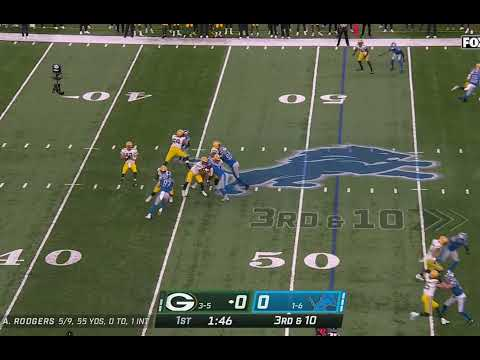

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('5gztKA3V1lw', width=650, height=450)

Rodgers' pre-snap diagnosis was spot-on — Allen Lazard drew the one-on-one matchup in man coverage and capitalized with a 47-yard reception. By EPA, it was the Packers' most valuable offensive play out of their 550 snaps in our dataset.


Given this payoff, it’s clear why quarterbacks devote so much time to spotting man/zone tells. Three-time Pro Bowl QB Alex Smith illustrates Peyton Manning’s pre-snap mindset on the [Glue Guys podcast](https://joincolossus.com/episode/chatter-matters/):


> “He’s [Peyton] taking in all these little pieces of information. The front, the linebacker & corner placements… that’s why they’re watching the film all week — to identify this because, again, this is all happening in a couple of seconds.”


In this paper, we present a tool that predicts man or zone coverage before the snap, adding another layer to film study. It has two core features:

* An interactive digital whiteboard that lets users reposition players and immediately see how different defensive alignments affect coverage probabilities.

* A breakdown of team-specific defensive “giveaways,” such as a safety cheating back, that regularly reveal coverage intentions.


## II. Model Architecture & Accuracy

Drawing from [Song et. al (2023)](https://cdn.prod.website-files.com/5f1af76ed86d6771ad48324b/63fe7c3baf598410cf4fbff3_Explainable%20Defense%20Coverage%20Classification%20in%20NFL%20Games%20using%20Deep%20NN.pdf) — a joint paper between Amazon ML Solutions Lab and NFL’s NGS group — we were encouraged by the use of attention layers in coverage classification. This insight, combined with the framework established by SumerSports’ [Ranasaria & Vabishchevich (2024)](https://github.com/SumerSports/SportsTrackingTransformer/blob/main/Attention%20is%20All%20You%20Need%2C%20for%20Sports%20Tracking%20Data.pdf), led us to implement a Transformer-based architecture. A brief overview of the model can be found below:

![Description](https://i.imgur.com/ibShcLT.jpeg)

* **1) Training Data:** As laid out in Ranasaria & Vabishchevich (2024), we train on independent frames from Weeks 1-8 as opposed to plays. This is advantageous as; 1) we increase our set of training data to roughly ~700k frames, and 2) this allows easier portability to our frontend tool. We add additional training frames by mirroring across the y-axis on 33% of frames. Notably, we bias this mirrored set towards the pre-snap, enabling the model to prioritize these frames in training. A distribution of our training frames can be found in the figure above. To reduce computation, we downsample by a factor of two and filter out rush attempts.

* **2) Model Architecture:** We use a single Transformer architecture with two attention heads. We first normalize our input features and transform them into higher-dimensional embeddings, allowing the model to capture subtle spatial relationships (like a linebacker shading inside). These embeddings feed into our 4-layer Transformer, which excels at learning how players move and interact with each other (such as defenders exchanging coverage responsibilities during a WR motion). The model then consolidates this information through pooling to arrive at a single man/zone prediction for each frame.

* **3) Results:** In the pre-snap, our Week 9 man/zone prediction accuracy reaches a high of **89%** and peaks at **93%** one second after the snap. As a benchmark, the Amazon-NFL model tested at 95.4% but had access to ~8x more data and trained primarily on post-snap frames (which are more informative). We are generally satisfied with our results but believe there is room for improvement.

Despite training & testing on independent frames, we find frame-to-frame probabilities in a play to be stable. An animation of Allen Lazard’s 47-yard catch demonstrates this below:

In [2]:
from IPython.display import HTML
HTML('<div style="padding:100% 0 0 0;position:relative;"><iframe src="https://player.vimeo.com/video/1042478451?badge=0&amp;autopause=0&amp;player_id=0&amp;app_id=58479" frameborder="0" allow="autoplay; fullscreen; picture-in-picture; clipboard-write" style="position:absolute;top:0;left:0;width:100%;height:100%;" title="Lazard - Line Graph &amp; Dots"></iframe></div><script src="https://player.vimeo.com/api/player.js"></script>')

Notably, Aaron Rodgers and the model pick up the same clue. The model peaks at 90% man confidence when Anzalone sprints to line up against Tonyan on the outside.

While this is a clear-cut example, the model can also detect subtle indicators that may escape human observation. In the following play, the Panthers motion WR Shi Smith into a 2x2 set. The nickel follows and by most indications, the Bengals are in man-to-man coverage.

In [3]:
from IPython.display import HTML
HTML('<div style="padding:75% 0 0 0;position:relative;"><iframe src="https://player.vimeo.com/video/1042562986?badge=0&amp;autopause=0&amp;player_id=0&amp;app_id=58479" frameborder="0" allow="autoplay; fullscreen; picture-in-picture; clipboard-write" style="position:absolute;top:0;left:0;width:100%;height:100%;" title="resized"></iframe></div><script src="https://player.vimeo.com/api/player.js"></script>')

* *Viewing note: Best to view game footage clip (top left) first, then replay & view probability shifts on the right.*

The model initially indicates man coverage as the nickel trails, but once the linebackers shift and the nickel shades inside, it correctly identifies that the Bengals are in a disguised zone look. Safety Jessie Bates gains depth moments before the snap, and the model further spikes to a 98% zone coverage prediction. We are encouraged by these types of plays as they demonstrate the model's ability to detect more nuanced defensive signals that humans may overlook.


## III. A Digital Whiteboard

With the model calibrated, we move to our frontend tool designed to complement traditional film study. While film review is invaluable, it's inherently limited by sample size — quarterbacks and analysts can only study the finite number of plays a defense has shown. Our interactive tool bridges this gap by letting users experiment with infinite defensive alignments, turning discrete game film into a continuous learning experience.

Inspired by [this tweet](https://x.com/SyedSchemes/status/1614899781385461761) by SumerSports' Shawn Syed, we recreated the pre-snap alignments from the following play. The Chargers check into a disguised Cover 2 look but indicate a Cover 1 Man Robber coverage with early safety movements. Still, before the snap, #24 Nasir Adderly (circled in red) gains depth — cheating to cover his half of the field and giving away the Cover 2 look. Trevor Lawrence, however, fails to recognize Adderly's giveaway and throws an interception. Our digital whiteboard (bottom half of video) illustrates how pivotal this movement was.

In [4]:
from IPython.display import HTML
HTML('<div style="padding:100% 0 0 0;position:relative;"><iframe src="https://player.vimeo.com/video/1044365251?badge=0&amp;autopause=0&amp;player_id=0&amp;app_id=58479" frameborder="0" allow="autoplay; fullscreen; picture-in-picture; clipboard-write" style="position:absolute;top:0;left:0;width:100%;height:100%;" title="Jacksonville-Los Angeles Whiteboard Example"></iframe></div><script src="https://player.vimeo.com/api/player.js"></script>')

Had Addderly shifted towards the center of the field (confirming the Robber look), the probability of zone coverage dips to 29%. Even though the defensive backs showed press coverage on all receivers (typically indicating man-to-man), the model weighted Adderly's movement as the decisive factor in correctly predicting zone coverage.

Similary in this [next example](https://x.com/SyedSchemes/status/1838296432513888501) (also derived from Syed, thanks Shawn!), the Broncos disguise Cover 2 with a man coverage look, with Surtain pressed up against Evans at the line of scrimmage (circled in blue). DB Ja'Quan McMillian (#29 - circled in red), however, shades Godwin's outer shoulder and plays ~5 yards off. McMillian's alignment signals to our model that the Broncos are likely playing zone coverage.

As we recreate this play in our digital whiteboard, we find that McMillian is the "key-man" in this coverage that Mayfield should be reading. If McMillian aligns in press coverage, there's a 39% chance of zone coverage. As he plays off, however, the probability of zone coverage increases to 60% even with Surtain's press look.

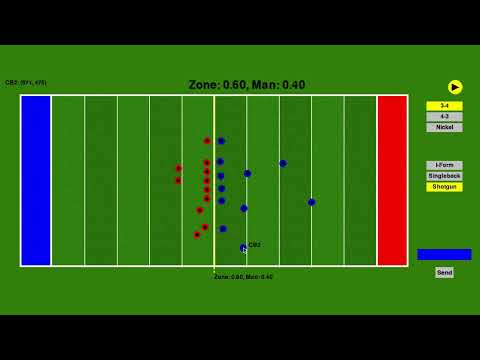

In [5]:
from IPython.display import YouTubeVideo
YouTubeVideo('GTQb3nncZxc', width=650, height=450)

Mayfield was ultimately fooled by the Broncos' look despite McMillian's giveaway. He progressed to Evans on the backside (likely expecting 1-on-1 coverage) only for Broncos S Brandon Jones to jump the pass.

We believe the power of this digital whiteboard lies in its ability to experiment with "leverage players" like McMillian and Adderly, whose pre-snap movements impact coverage odds. For example, if an offense identifies a handful of promising plays against a particular defense, they can recreate that defense's tendencies in the whiteboard to understand the spectrum of pre-snap looks they might face. From here, the offense can pinpoint which defensive players are important to read and how their specific movements telegraph coverage intentions. From here, we move to compiling these giveaways on a general basis.

**Our frontend tool is linked [here](https://vishakhs.itch.io/kagglenfl25)!**

## IV. Compiling Pre-Snap Tells

In [this](https://vimeo.com/97245230) interview, Aaron Rodgers provides a window into the quarterback's pre-snap mental process:

> “When you see it and you've experienced it, you're able to not let your thoughts overtake your ability to react to what you're seeing.”

This quote reveals a crucial truth: in the compressed timeframe before the snap, quarterbacks are forced to rely on pattern recognition and cognitive shortcuts rather than methodical analysis.

Our next section aims to equip quarterbacks with these cognitive shortcuts. By analyzing sudden swings in our model's coverage predictions, we can pinpoint which defenders most frequently telegraph their team's coverage and how they do it.

To maximize our sample size, we expanded our analysis to all weeks using a leave-one-week-out training approach (i.e. week 5 predictions were trained on weeks 1-4, and 6-9). We then identified **significant** coverage giveaways by focusing on probability shifts of 10% or more within half a second (approximately 3.5 times the Median Absolute Deviation of probabilites in the pre-snap) to ensure we captured genuine coverage swings rather than noise.

**For plays without motion**, we work backwards from these probability swings by analyzing each defender's velocity vectors (vx, vy) Euclidean distance to the origin. The defender with the largest distance is flagged as the "tell" player. While we explored more sophisticated outlier detection methods like DBSCAN, this simple distance-based approach proved most effective in a manual random review of 10 plays. We then chart these key defenders' **giveaway paths** from standard alignments (middle linebacker, slot corner, outside corner, safety) inspired by [Eager et. al (2024)](https://www.sloansportsconference.com/research-papers/using-tracking-data-to-build-offensive-line-development-tools). The graphic below serves as a “zone tell sheet” created for the Patriots to analyze how their rivals reveal zone coverage:

![Description](https://i.imgur.com/Gu6Sa6j.jpeg)

**For plays with motion**, we felt uncomfortable signaling out one player as the coverage indicator. Given the coordinated nature of responses to motion, we built off of [Fernández and Bornn (2018)](https://www.lukebornn.com/papers/fernandez_ssac_2018.pdf) and opted for team-based heatmaps instead. The graphic below illustrates the Panthers’ man vs. zone response to fly/jet motion moving from right to left:

![Description](https://i.imgur.com/yaJzPG8.jpeg)

* *Viewing note: Red dots represent WR starting points in motion. Black paths chart the motion.*

The heatmaps align with traditional football wisdom — in man coverage, we see a clear “trailing” pattern as the DB tracks the motioning receiver, while zone coverage shows a more distributed defensive adjustment. While our current sample size limits broader conclusions, this hot/cold spot visualization framework could prove valuable for identifying coverage tendencies created by specific motion responses.

## V. Conclusion

Throughout this process, we anchored on Amazon TNF Producer Sam Schwartzstein's appearance on [*The Athletic Football Show*](https://deepcast.fm/episode/the-state-of-nfl-stats-and-a-falcons-eagles-recap-with-amazons-sam-schwartzstein-qb-counseling-for-bryce-young-and-the-panthers-with-steven-ruiz). During the interview, he discussed their broadcasts' blitz identification model.

> “Sean Payton talked about it as his new view. He now has a different view on blitzing because of what he saw Defensive Alerts [Amazon’s blitz prediction model] do. A lot of the times it fits normal ‘football guy’ rules, but then there’s times where I was like, I have no idea why this player is highlighted. And then he blitzes.”

Just as the blitz model revealed subtle blitzing patterns to Payton, our model can expose coverage giveaways that may elude experienced eyes. For example, it accurately identified the Bengals’ disguised zone coverage in Part II, showcasing its ability to detect subtleties often overlooked in real time.

We also hope our frontend tool helps teams explore alternative defensive alignments beyond film study, allowing quarterbacks to develop intuitive pattern recognition for split-second pre-snap decisions. While quarterbacks already notice obvious coverage giveaways (like a CB’s early backpedal), coordinator-specific models could uncover more nuanced patterns. Training on an unconventional defense, such as Wink Martindale’s 2022 unit, may highlight unique pre-snap tells, though sample sizes remained a limiting factor for us given our dataset.

## VI. Future Work

* We would be eager to train a model recognizing “telling” movements in zone coverages (Cover 6, Cover 3, etc.) immediately after the snap, primarily from the deep safeties.

* We believe our “tell recognition” methodology can be improved. A modified version (tailored to Transformer models) of Song et. al’s (2023) Guided GradCAM algorithm can “light up” specific positional interactions causing changes in predictions. We considered [Alcorn & Nguyen (2021)’s](https://arxiv.org/abs/2102.03291) 2D UMAP methodology, but wanted to highlight player movements paths.

* With higher computing capabilities, we would look forward to improving the model. For instance, Alcorn & Nguyen (2021) and [Vaswani et. al (2017)](https://arxiv.org/abs/1706.03762) outnumber our hyperparameters by a factor of four.

## VII. Appendix

* All code found [here](https://github.com/smitbajaj/ExposingCoverageTells-BDB25/tree/main).
* Final word count: 1992
* Final figure count: 8

Feel free to reach out to [Smit Bajaj](https://x.com/SBajajSports) for any modeling/visualization questions and/or [Vishakh Sandwar](https://www.linkedin.com/in/vishakhs/) for any frontend questions!

A huge thank you to Shawn Syed + Udit Ranasaria from SumerSports for their guidance, both from a schematic & technical lens! Another big thank you to Tej Seth for inspriation on path charting!